# Step 0: Load modules and set parameters

In [1]:
import os
from tqdm import tqdm

import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

print(torch.__version__)

2.1.0a0+4136153


In [2]:
batch_size = 128
epochs = 5

use_gpu = True
dataset_loc = './mnist_data'

# Step 1a: Load data

In [3]:
transform = transforms.Compose([
    transforms.ToTensor() # convert and scale
])

train_dataset = datasets.MNIST(dataset_loc,
                               download=True,
                               train=True,
                               transform=transform)
test_dataset = datasets.MNIST(dataset_loc,
                              download=True,
                              train=False,
                              transform=transform)

train_loader = DataLoader(train_dataset,
                          batch_size=batch_size,
                          shuffle=True,
                          num_workers=4,
                          pin_memory=True)
val_loader =   DataLoader(test_dataset,
                          batch_size=batch_size,
                          shuffle=False,
                          num_workers=4,
                          pin_memory=True)

# Step 1b: Inspect the data samples

torch.Size([128, 1, 28, 28])


#### **Label:** 7

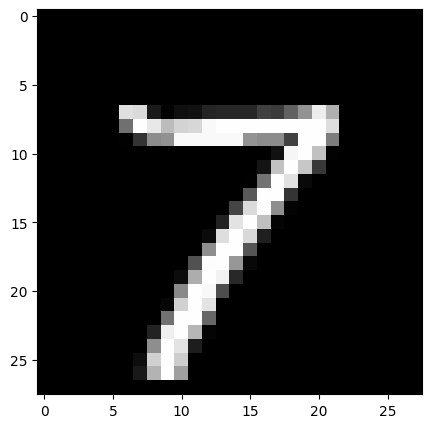

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Markdown, display

# Just visualize the first element of the first batch
# Press <CTRL>-<RETURN> to reiterate the same cell
for item in train_loader:
    print(item[0].shape)
    img = item[0][0, 0, :, :]
    #img = np.stack((img,)*3, axis=-1)
    fig, ax = plt.subplots(figsize=(5,5))
    im = ax.imshow(img, cmap='gray', vmin=0, vmax=1)
    display(Markdown("#### **Label:** {}".format(item[1][0])))
    plt.show()
    break

# Step 2: Create model

In [5]:
def create_model():
    model = nn.Sequential(
        nn.Linear(28*28, 128),  # Input: 28x28(x1) pixels
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Linear(128, 128),
        nn.ReLU(),
        nn.Linear(128, 10, bias=False)  # Output: 10 classes
    )
    return model

model = create_model()

# Step 3: Run training

In [7]:
if use_gpu:
    device = torch.device("cuda:{}".format(0))
    model = model.to(device)

optimizer = optim.SGD(model.parameters(), lr=0.01)
loss = nn.CrossEntropyLoss()

# Main training loop
for i in range(epochs):
    model.train()
    #train_loader.sampler.set_epoch(i)

    # Training steps per epoch
    epoch_loss = 0
    pbar = tqdm(train_loader)
    for x, y in pbar:
        if use_gpu:
            x = x.to(device, non_blocking=True)
            y = y.to(device, non_blocking=True)

        x = x.view(x.shape[0], -1) # flatten
        optimizer.zero_grad()
        y_hat = model(x)
        batch_loss = loss(y_hat, y)
        batch_loss.backward()
        optimizer.step()
        batch_loss_scalar = batch_loss.item()
        epoch_loss += batch_loss_scalar / x.shape[0]
        pbar.set_description(f'training batch_loss={batch_loss_scalar:.4f}')

    # Run validation at the end of each epoch
    with torch.no_grad():
        model.eval()
        val_loss = 0
        pbar = tqdm(val_loader)
        for x, y in pbar:
            if use_gpu:
                x = x.to(device, non_blocking=True)
                y = y.to(device, non_blocking=True)

            x = x.view(x.shape[0], -1) # flatten
            y_hat = model(x)
            batch_loss = loss(y_hat, y)
            batch_loss_scalar = batch_loss.item()

            val_loss += batch_loss_scalar / x.shape[0]
            pbar.set_description(f'validation batch_loss={batch_loss_scalar:.4f}')

    print(f"Epoch={i}, train_loss={epoch_loss:.4f}, val_loss={val_loss:.4f}")
    
torch.save(model.state_dict(), 'model.pt')

validation batch_loss=0.6397: 100%|████████████| 79/79 [00:00<00:00, 272.70it/s]


Epoch=0, train_loss=4.6721, val_loss=0.5125


validation batch_loss=0.4033: 100%|████████████| 79/79 [00:00<00:00, 275.66it/s]


Epoch=1, train_loss=2.5633, val_loss=0.3416


validation batch_loss=0.3014: 100%|████████████| 79/79 [00:00<00:00, 264.80it/s]


Epoch=2, train_loss=1.9748, val_loss=0.2787


validation batch_loss=0.2517: 100%|████████████| 79/79 [00:00<00:00, 276.60it/s]


Epoch=3, train_loss=1.7147, val_loss=0.2470


validation batch_loss=0.2305: 100%|████████████| 79/79 [00:00<00:00, 276.79it/s]


Epoch=4, train_loss=1.5580, val_loss=0.2279


# Step 4: Evaluate results

Confusion matrix, without normalization


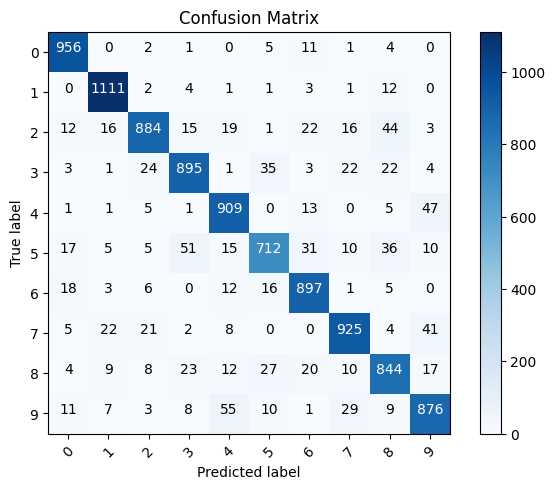

In [16]:
# Print confusion matrix
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix'):
    import itertools
    import matplotlib.pyplot as plt
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    cmap=plt.cm.Blues
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

y_true = np.empty((0,), dtype=int, order='C')
y_pred = np.empty((0,), dtype=int, order='C')
model.eval()
for test_x, test_y in val_loader:
    y_true = np.concatenate((y_true, test_y.numpy()))
    
    if use_gpu:
        test_x = test_x.to(device, non_blocking=True)

    x = test_x.view(test_x.shape[0], -1) # flatten
    with torch.no_grad():
        this_pred = model(x).cpu()
    y_pred = np.concatenate((y_pred, this_pred.argmax(axis=-1)))
    
cm = confusion_matrix(y_true, y_pred)
cm_plot_labels = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

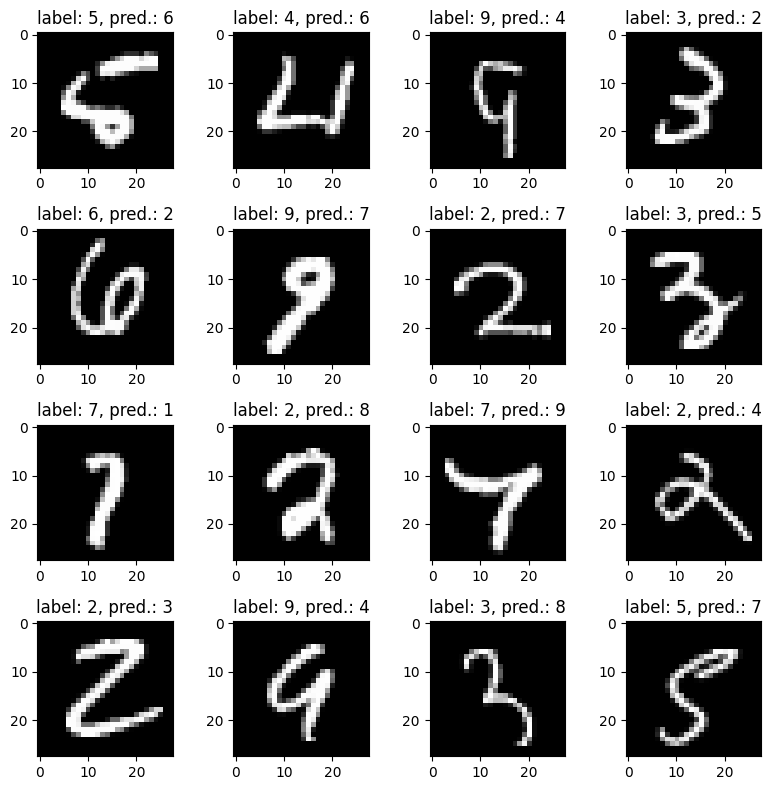

In [12]:
cur_image = 0
num_images = 16
fig = plt.figure(figsize=(8,8))

for (test_val, pred_y) in zip(DataLoader(test_dataset, batch_size=1), y_pred):
    if  test_val[1].numpy() != pred_y: # Only where prediction and ground truth are different!
        cur_image += 1
        img = test_val[0][0,0,:, :]
        ax = fig.add_subplot(4, 4 ,cur_image)
        im = ax.imshow(img, cmap='gray', vmin=0, vmax=1)
        ax.set_title("label: {}, pred.: {}".format(test_val[1][0].numpy(), pred_y))

        if num_images == cur_image:
            break
plt.tight_layout()
plt.show()